<a href="https://colab.research.google.com/github/BluBloos/3D-Hand-Tracking/blob/main/src/HandTracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

## Run ONLY when in Colab

In [ ]:
!echo "Initializing github repository"
!ls -la
!rm -r .config/
!rm -r sample_data/
!git clone https://github.com/BluBloos/QMIND2021-2022/ .

## Always Run

In [1]:
!git pull # Download updated project from Github.

##### HANDLE DIFFS WHEN RUNNING IN COLAB #####
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print("In Colab:", IN_COLAB)
import sys
if (IN_COLAB):
  sys.path.insert(1, '/content/src/')
##### HANDLE DIFFS WHEN RUNNING IN COLAB #####

######### EXTERNAL LIBRARIES #########
import os
import pickle
import matplotlib.pyplot as plt
import imageio
import numpy as np
import time
import tensorflow as tf
#NOTE: Good resource. -> https://www.tensorflow.org/tutorials/quickstart/advanced
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, MaxPool2D
from tensorflow.keras import Model
print("TensorFlow version:", tf.__version__)
import random
from qmindcolors import cstr
import cv2
!pip install chumpy
######### EXTERNAL LIBRARIES #########

fatal: invalid refspec 'Github.'


In Colab: False
TensorFlow version: 2.8.0


## Load Annotations

Running this block will populate y_train and y_test

In [2]:
anno_train_path = os.path.join("data", "anno", "anno_training.pickle") if IN_COLAB else \
    os.path.join("..", "RHD_small", "training", "anno_training.pickle")
anno_eval_path = os.path.join("data", "anno", "anno_evaluation.pickle") if IN_COLAB else \
    os.path.join("..", "RHD_small", "evaluation", "anno_evaluation.pickle")

# NOTE: We note that the numbers 41258 and 2728 were retrieved directly from
# https://lmb.informatik.uni-freiburg.de/resources/datasets/RenderedHandposeDataset.en.html
TRAIN_TOTAL_COUNT = 41258
EVALUATION_TOTAL_COUNT = 2728

y_train = np.zeros((TRAIN_TOTAL_COUNT, 21, 3))
y_test = np.zeros((EVALUATION_TOTAL_COUNT, 21, 3))
k_train = np.zeros((TRAIN_TOTAL_COUNT, 3, 3))
k_test = np.zeros((EVALUATION_TOTAL_COUNT, 3, 3))
y2_train = np.zeros((TRAIN_TOTAL_COUNT, 21, 2))
y2_test = np.zeros((EVALUATION_TOTAL_COUNT, 21, 2))

def load_anno(path, y, k, y2):
  anno_all = []
  count = 0
  with open(path, 'rb') as f:
    anno_all = pickle.load(f)
  for key, value in anno_all.items():
    kp_visible = (value['uv_vis'][:, 2] == 1)
    case1 = np.sum(kp_visible[0:21])
    case2 = np.sum(kp_visible[21:])
    leftHand = case1 > 0
    # NOTE: We note here that we are not checking if this training or evaluation example is valid.
    # i.e. we want to densely store the annotations.
    if(not leftHand):
        y[count, :, :] = value['xyz'][21:42]
        y2[count, :, :] = value['uv_vis'][:, :2][21:42]
    else: 
        y[count, :, :] = value['xyz'][:21]
        y2[count, :, :] = value['uv_vis'][:, :2][:21]

    # Adjust the 3D keypoints to be at the center of the image.
    annot_3D = y[count, :, :]
    y[count, :, :] -= np.array([annot_3D[0][0], annot_3D[0][1], 0.0], dtype=np.float32)

    k[count, :, :] = value['K']
    count += 1

print("Loading in training annotations")
time_start = time.time()
load_anno(anno_train_path, y_train, k_train, y2_train)
time_end = time.time()
print(cstr("Training annotations loaded in {} s".format(time_end - time_start)))
print("Loading in evaluation annotations")
time_start = time.time()
load_anno(anno_eval_path, y_test, k_test, y2_test)
time_end = time.time()
print(cstr("Evaluation annotations loaded in {} s".format(time_end - time_start)))

Loading in training annotations
Training annotations loaded in 3.5048351287841797 s
Loading in evaluation annotations
Evaluation annotations loaded in 0.1605689525604248 s


# DATA LOADING

IMAGE_SIZE, GRAYSCALE, and BATCH_SIZE should generally not be changed.

In [3]:
IMAGE_SIZE = 224
GRAYSCALE = False
BATCH_SIZE = 1

In [4]:
IMAGE_CHANNELS = 1 if GRAYSCALE else 3

# NOTE(Noah): gcs code will only work on the Colab. It works on either Ubuntu or macOS (no Windows support).
# I attempted to install gcsfuse on my macOS machine, but it did not work.
# gsfuse is beta software.
if IN_COLAB:
  from google.colab import auth
  auth.authenticate_user()
  # we know that we are on an Ubuntu machine.
  # Thus, installing gcsfuse will be done via the Ubuntu instructions.
  # https://github.com/GoogleCloudPlatform/gcsfuse/blob/master/docs/installing.md#ubuntu-and-debian-latest-releases
  !echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
  !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
  # -y in apt-get will assume "yes" as the answer to all prompts.
  # -q in apt-get will make things "quiet" for us. Nice!
  !sudo apt-get -y -q update
  !sudo apt-get -y -q install gcsfuse
  !mkdir -p data
  !gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 shd_final data

# NOTE(Noah): Stole this function from Stackoverflow :)
def rgb2gray(rgb):
  return np.expand_dims(np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]), axis=2)
    
def resize(img, size):
  return cv2.resize(img, dsize=(size, size), interpolation=cv2.INTER_CUBIC)
  
def download_image(root_dir, set, img_index):
  file_path = os.path.join(root_dir, set, "color", "{:05d}.png".format(img_index))
  image = imageio.imread(file_path)
  _image = image.astype('float32')
  if GRAYSCALE:
    _image = rgb2gray(_image / 255)
  else:
    _image = _image / 255

  annot_2D = y2_train[img_index]
  if set == "evaluation":
    annot_2D = y2_test[img_index]
  pixel_trans = np.array([160,160]) - annot_2D[0]
  x_shift = int(pixel_trans[0])
  y_shift = int(pixel_trans[1])
  _image = np.roll( _image, (y_shift, x_shift), axis=(0,1) )

  # black out the regions we do not care about
  if y_shift > 0:
    _image = cv2.rectangle(_image, (0, 0), (320, y_shift), 0, -1)
  else:
    _image = cv2.rectangle(_image, (0, 320 + y_shift), (320, 320), 0, -1)

  if x_shift > 0:
    _image = cv2.rectangle(_image, (0, 0), (x_shift, 320), 0, -1)
  else:
    _image = cv2.rectangle(_image, (320 + x_shift, 0), (320, 320), 0, -1)

  _image = resize(_image, IMAGE_SIZE)

  return _image

# TODO(Noah): Reimplement the code that sets up SH_RHD.
gcs_path = 'data' if IN_COLAB else os.path.join("..", "SH_RHD")
train_list = os.listdir(os.path.join(gcs_path, "training/color"))
eval_list = os.listdir(os.path.join(gcs_path, "evaluation/color"))

# Below, we implement stochastic subsampling of the train and eval list so
# that our model will train in a reasonable amount of time.
DESIRED_BATCH_COUNT = min(16, len(train_list) // BATCH_SIZE)
print(cstr("DESIRED_BATCH_COUNT ="), DESIRED_BATCH_COUNT)
print(cstr("DESIRED_BATCH_COUNT"), "is the batches per epoch to train w/")
DESIRED_TEST_BATCH_COUNT = min(16, len(eval_list) // BATCH_SIZE)
print(cstr("DESIRED_TEST_BATCH_COUNT ="), DESIRED_BATCH_COUNT)
print(cstr("DESIRED_TEST_BATCH_COUNT"), "is the batches per epoch to test w/")


DESIRED_BATCH_COUNT = 16
DESIRED_BATCH_COUNT is the batches per epoch to train w/
DESIRED_TEST_BATCH_COUNT = 16
DESIRED_TEST_BATCH_COUNT is the batches per epoch to test w/


# MODEL LOADING

In [5]:
MANO_DIR = os.path.join("data", "mano_v1_2") if IN_COLAB else os.path.join("..", "mano_v1_2")
from mobilehand import MAKE_MOBILE_HAND
from mobilehand_lfuncs import LOSS_3D
MOBILE_HAND = MAKE_MOBILE_HAND(IMAGE_SIZE, IMAGE_CHANNELS, BATCH_SIZE, MANO_DIR)
model = MOBILE_HAND

### MODEL FORWARD PASS TEST ###
input_test = tf.random.uniform(shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS))
input_test = tf.cast(input_test, tf.float32)
output_test = MOBILE_HAND((input_test, 
    np.repeat(np.array([[1]]), repeats=32), 
    tf.repeat(tf.constant([[0, 0, 0]]), repeats=32, axis=0) ))
print(cstr("output_test ="), output_test)
### MODEL FORWARD PASS TEST ###

from mobilehand_lfuncs import LOSS
from mano_layer import MANO_Model
_mpi_model = MANO_Model(MANO_DIR)
# TODO(Noah): Expose U and L directly on our mobilehand implementation.
U = _mpi_model.U
L = _mpi_model.L
loss_fn = lambda beta, pose, L, U, pred, gt : LOSS(beta, pose, L, U, pred, gt)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 288)               182880    
                                                                 
 dropout_1 (Dropout)         (None, 288)               0         
                                                                 
 dense_1 (Dense)             (None, 288)               83232     
                                                                 
 dropout_2 (Dropout)         (None, 288)               0         
                                                                 
 dense_2 (Dense)             (None, 58)                16762     
                                                                 
Total params: 282,874
Trainable params: 282,874
Non-trainable params: 0
_________________________________________________________________
MANO Differentiable Layer Loaded
output_test = [

# TRAINING

## Training Setup

In [ ]:
class StupidSimpleLossMetric():
    def __init__(self):
        self.losses = [] # empty python array 
    def __call__(self, loss):
        self.losses.append(loss)
    def result(self):
        return sum(self.losses) / len(self.losses)
    def reset_states(self):
        self.losses = []

optimizer = tf.keras.optimizers.Adam() # defaults should work just fine
train_loss = StupidSimpleLossMetric()
test_loss = StupidSimpleLossMetric()

@tf.function
def train_step(input, scale, z_depth, gt):
    with tf.GradientTape() as tape:
        beta, pose, mesh, keypoints = model((input, scale, z_depth))
        #loss = loss_func(predictions, segmentation_masks)
        #loss = np.dot(tf.reshape(segmentation_masks, [102400], tf.reshape(predictions, [102400])
        #loss = loss_fn(keypoints, gt)
        loss = loss_fn(beta, pose, L, U, keypoints, gt)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
    #train_accuracy(labels, predictions)
  
@tf.function
def test_step(images, scale, z_depth, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  beta, pose, mesh, keypoints = model((images, scale, z_depth), training=False)
  return loss_fn(beta, pose, L, U, keypoints, labels)
  #test_accuracy(labels, predictions)

checkpoint_path = os.path.join("data", "checkpoints") if IN_COLAB else os.path.join("..", "checkpoints/")

if not IN_COLAB:
    from render_ckpt import render_checkpoint_image

## Training Loop

The variable LAST_CHECKPOINT controls where our model training will start off from.
Leave as -1 to "start fresh".
OR adjust to any number, so long as there is a checkpoint saved for that number.

You may also adjust EPOCHS as you wish.

In [ ]:
LAST_CHECKPOINT = -1
EPOCHS = 10 # sure...

In [ ]:
!mkdir $checkpoint_path

random.shuffle(train_list)
random.shuffle(eval_list)
# numpy "buckets" that we will use to load things in.
x_train = np.zeros( (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS) )
x_test = np.zeros( (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS) ) 

LAST_CHECKPOINT = -1
if (LAST_CHECKPOINT > -1):
  file_path = os.path.join(checkpoint_path, "cp-{:04d}.ckpt".format(LAST_CHECKPOINT))
  model.load_weights(file_path)
  print(cstr("Loaded weights from {}".format(file_path)))
LAST_CHECKPOINT = 0

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  print("Begin epoch", epoch)
  start = time.time()
  train_loss.reset_states()
  test_loss.reset_states()
  
  y = np.zeros([BATCH_SIZE, 21, 3], dtype=np.float32)
  
  for i in range(DESIRED_BATCH_COUNT):
    for j in range(BATCH_SIZE):
      filename = train_list[j + i * BATCH_SIZE]
      y_index = int(filename[0:5])
      train_image = download_image(gcs_path, "training", y_index)
      x_train[j,:,:,:] = train_image
      y[j, :, :] = y_train[y_index]

    x_train = x_train.astype('float32')
    
    # TODO(Noah): Do something with this constant value as it is used quite a bit thru the codebase.
    scale = np.sqrt(np.sum(
      np.square(y[:, 0] - y[:, 8]), axis=1, keepdims=True)) / 0.1537328322252615
    z_depth = tf.constant(y[:, 0])

    loss = train_step(x_train, scale, z_depth, y)
    train_loss(loss.numpy())

  end = time.time()

  print(
    f'Epoch {epoch}, '
    f'Time {end-start} s'
    f'Loss: {train_loss.result()}, '
    #f'Test Loss: {test_loss.result()}, '
  )

  # Save the model parameters
  if (epoch % 1 == 0) or (epoch == EPOCHS - 1):
    ckpt_index = LAST_CHECKPOINT + epoch
    checkpoint_filepath = os.path.join(checkpoint_path, "cp-{:04d}.ckpt".format(ckpt_index))
    model.save_weights(checkpoint_filepath)
    print(cstr("Saved weights to {}".format(checkpoint_filepath)))

    if not IN_COLAB:
      # Run the model on image 19 of the evaluation images.
      test_img = 19
      eval_image = download_image(gcs_path, "evaluation", test_img)
      eval_image = eval_image.astype('float32')
      annot = (y2_test[test_img], y_test[test_img], k_test[test_img])
      render_checkpoint_image(checkpoint_path, ckpt_index, model, eval_image, annot)

## Training Loop to Test Overfitting

Here we implement a training loop to test if we can overfit the model on just one image. We believe that this test will generally validate our model architecture and it's trainability. We have been having major issues with underfitting, and we belive that passing this overfit test is key to our success.

In [ ]:
!mkdir $checkpoint_path

last_checkpoint = -1
if (last_checkpoint > -1):
  file_path = os.path.join(checkpoint_path, "cp-{:04d}.ckpt".format(last_checkpoint))
  model.load_weights(file_path)
  print(cstr("Loaded weights from {}".format(file_path)))

# load the crap AND we only have to do it ONE time because we are simply trying to overfit
# on the model.
y = np.zeros([BATCH_SIZE, 21, 3], dtype=np.float32)
x_train = np.zeros((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS))
selected_image = -1 # selected image
for j in range(BATCH_SIZE):
  filename = train_list[3]
  selected_image = int(filename[0:5])
  train_image = download_image(gcs_path, "training", selected_image)
  x_train[j,:,:,:] = train_image
  y[j, :, :] = y_train[selected_image]

# TODO(Noah): We are having serious issues with modularity of code. But we need to iterate fast and
# get something done.
scale = np.sqrt(np.sum(
  np.square(y[:, 0] - y[:, 8]), axis=1, keepdims=True)) / 0.1537328322252615
z_depth = tf.constant(y[:, 0])

EPOCHS = 10 # sure...

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  print("Begin epoch", epoch)
  start = time.time()
  train_loss.reset_states()
  test_loss.reset_states()
  
  x_train = x_train.astype('float32')
  loss = train_step(x_train, scale, z_depth, y)
  train_loss(loss.numpy())

  end = time.time()

  print(
    f'Epoch {epoch}, '
    f'Time {end-start} s'
    f'Loss: {train_loss.result()}, '
  )

  # Save the model parameters for EACH EPOCH
  checkpoint_filepath = os.path.join(checkpoint_path, "cp-{:04d}.ckpt".format(epoch))
  model.save_weights(checkpoint_filepath)
  print(cstr("Saved weights to {}".format(checkpoint_filepath)))

  if not IN_COLAB:
    # Run the model on image 19 of the evaluation images.
    test_img = selected_image
    eval_image = download_image(gcs_path, "training", test_img)
    eval_image = eval_image.astype('float32')
    annot = (y2_train[test_img], y_train[test_img], k_train[test_img])
    render_checkpoint_image(checkpoint_path, epoch, model, eval_image, annot)

## Test "render_checkpoint_image"

The block below will test the render_checkpoint_image subroutine. We load image 19 from the evaluation set of RHD as input into the subroutine. 

Note the template_override parameter of the function call. Setting this to true will ignore the evalution image and no forward pass will happen. Instead, the MANO template mesh will be rendered.

In [ ]:
IMG = 26
# Run the model on image 19 of the evaluation images.
eval_image = download_image(gcs_path, "training", IMG)
eval_image = eval_image.astype('float32')

annot_3D = y_train[IMG]
annot_2D = y2_train[IMG]
annot_K = k_train[IMG]
annot = (annot_2D, annot_3D, annot_K)

render_checkpoint_image(checkpoint_path, 0, model, eval_image, annot, template_override=False)

# MODEL EVALUATION

In [6]:
rhd_eval_dir = os.path.join(gcs_path, "evaluation", "color")

In [ ]:
from evaluation import time_model
time_model(model, rhd_eval_dir, download_image)

00011.png
00019.png
00020.png
00023.png
00027.png
00034.png
00038.png
00040.png
00042.png
00048.png
00049.png
00053.png
00054.png
00058.png
00060.png
00063.png
00064.png
00071.png
00072.png
00077.png
00080.png
00086.png
00088.png
00092.png
00093.png
00094.png
00095.png
00100.png
00103.png
00106.png
00114.png
00116.png
00117.png
00118.png
00122.png
00123.png
00124.png
00130.png
00145.png
00153.png
00156.png
00162.png
00163.png
00164.png
00165.png
00176.png
00181.png
00184.png
00188.png
00190.png
00192.png
00193.png
00201.png
00011.png
00019.png
00020.png
00023.png
00027.png
00034.png
00038.png
00040.png
00042.png
00048.png
00049.png
00053.png
00054.png
00058.png
00060.png
00063.png
00064.png
00071.png
00072.png
00077.png
00080.png
00086.png
00088.png
00092.png
00093.png
00094.png
00095.png
00100.png
00103.png
00106.png
00114.png
00116.png
00117.png
00118.png
00122.png
00123.png
00124.png
00130.png
00145.png
00153.png
00156.png
00162.png
00163.png
00164.png
00165.png
00176.png
00181.png


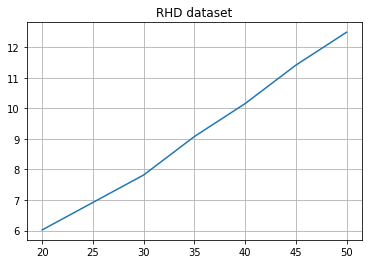

In [7]:
from evaluation import evaluate_model
checkpoint_path = os.path.join('../','checkpoints', "cp-{:04d}.ckpt".format(9))

model.load_weights(checkpoint_path)
evaluate_model(model, rhd_eval_dir, download_image, y_test, gcs_path)

In [ ]:
from evaluation import generate_loss_graph
generate_loss_graph(checkpoint_path, model, 
    rhd_eval_dir, download_image, y_test)